In [87]:
import time
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import sys
import os
import string
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
%matplotlib inline

In [88]:
df = pd.read_csv ('pfizer.csv')
df.head()

,username,date_and_time,tweet,hashtags,link
0,AurorasaSi,3/30/2022 22:40,"According to reports, a life insurance company...","['pfizer', 'psychopath', 'corruption']",https://twitter.com/AurorasaSi/status/15092694...
1,ChrisHubbard,3/30/2022 22:40,@angrybklynmom If they can scare people enough...,[],https://twitter.com/ChrisHubbard/status/150926...
2,JustLaElisa17,3/30/2022 22:40,Pfizer CEO Albert Bourla calls people who spre...,['lockhimup'],https://twitter.com/JustLaElisa17/status/15092...
3,thecliffadams,3/30/2022 22:40,@Upthefukcintics @Rstowitts @samkill @JamesLew...,[],https://twitter.com/thecliffadams/status/15092...
4,YannSolo15,3/30/2022 22:39,"Comme dirait @PatSebastien, c'est que d'l'amou...","['vaccins', 'vaccination', 'vaccines', 'covid_...",https://twitter.com/YannSolo15/status/15092691...


In [89]:
df = df[['tweet']]
df.head()

,tweet
0,"According to reports, a life insurance company..."
1,@angrybklynmom If they can scare people enough...
2,Pfizer CEO Albert Bourla calls people who spre...
3,@Upthefukcintics @Rstowitts @samkill @JamesLew...
4,"Comme dirait @PatSebastien, c'est que d'l'amou..."


In [90]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['stopwords']].head()

,stopwords
0,15
1,14
2,1
3,9
4,0


In [91]:
def cleanHtml(sentence): #removing html points
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence): #removing punctuation and special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|_|-]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence): #keeping only the whitespaces
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent


def decontraction(text): #removing decontractions
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    return text

In [92]:
df['tweet'] = df['tweet'].str.lower()
df['tweet'] = df['tweet'].apply(cleanHtml)
df['tweet'] = df['tweet'].apply(cleanPunc)
df['tweet'] = df['tweet'].apply(keepAlpha)
df['tweet'] = df['tweet'].apply(decontraction)

In [93]:
stop_words = list(set(stopwords.words('english')))
len(stop_words)

179

In [94]:
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

In [95]:
df['tweet'] = df['tweet'].apply(removeStopWords)

In [96]:
words_to_exclude = ["https", "vaccine", "covid", "pfizer"]

def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    cleaned_word = " ".join([word for word in text.split()
                            if all(ele not in word for ele in words_to_exclude)
                                and not word.startswith('@')
                                and word != 'RT'])
    wc = WordCloud(
    max_words=3000,
    min_word_length =3,
    collocation_threshold = 20,
    stopwords=stopwords,
    repeat=True)

    wc.generate(cleaned_word)
    
    return wc

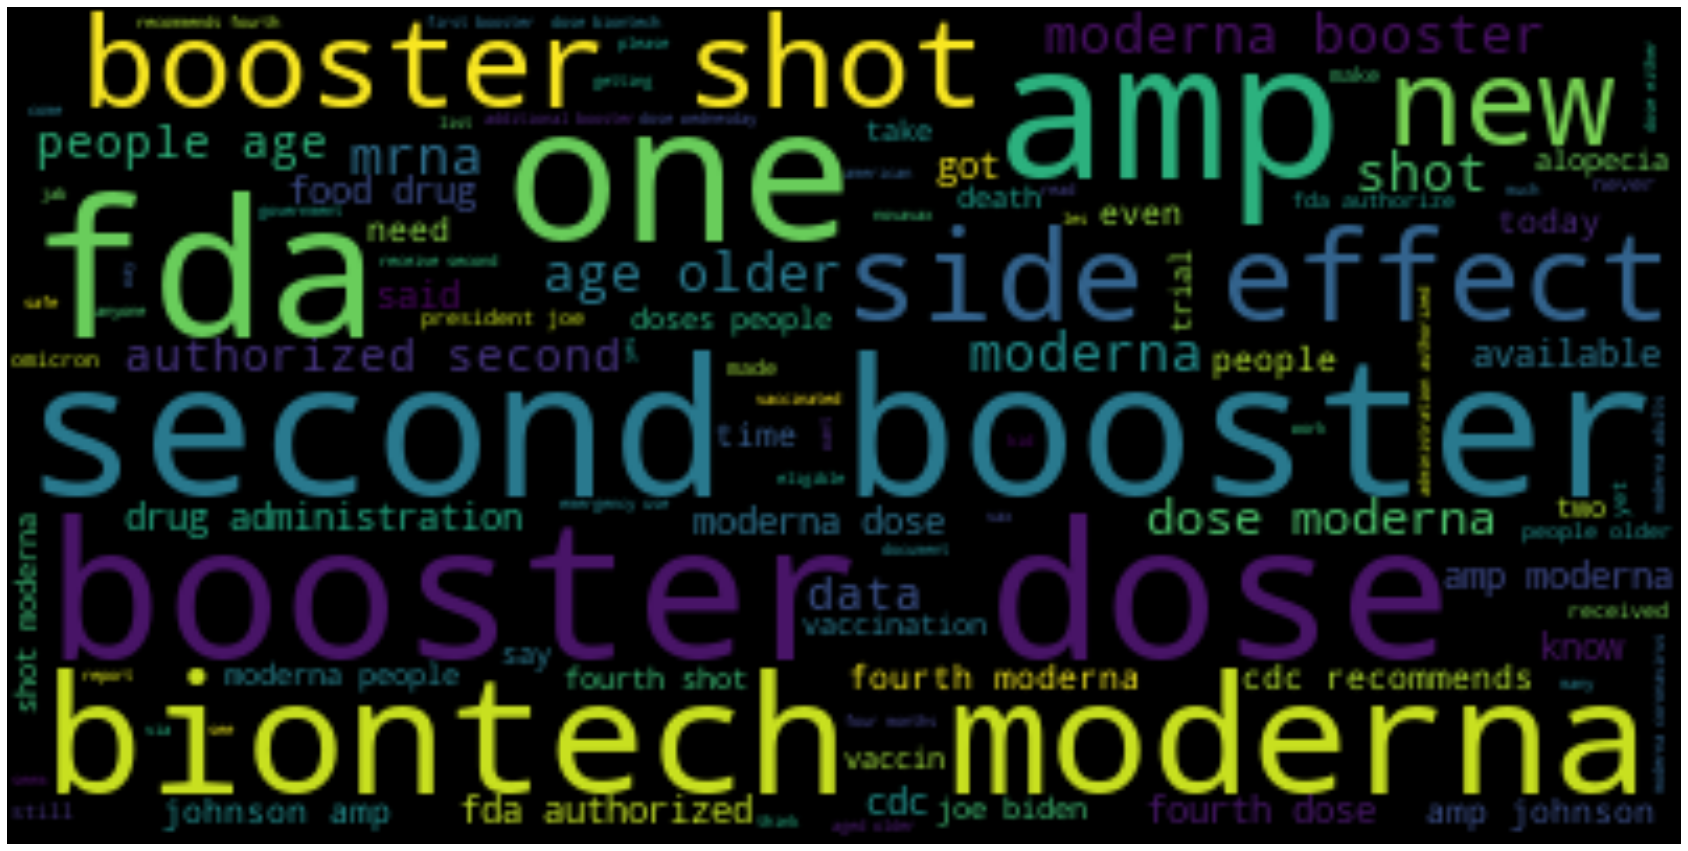

In [97]:
wordcloud =  create_wordcloud(' '.join(df['tweet']))
cloud = plt.figure(1,figsize=(30, 50))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [98]:
def percentage(part,whole):
    return 100 * float(part)/float(whole)

In [99]:
nltk.download('vader_lexicon')

positive = 0
negative = 0
neutral = 0

tweet_list = []

positive_list = []
negative_list = []
neutral_list = []

for i in range(df.shape[0]):
    tweet_list.append(df.tweet[i])
    score = SentimentIntensityAnalyzer().polarity_scores(df.tweet[i])
    
    pos = score['pos']
    neg = score['neg']
    neu = score['neu']
    
    comp = score['compound']
 
    if neg > pos:
        negative_list.append(df.tweet[i])
        negative += 1
    elif pos > neg:
        positive_list.append(df.tweet[i])
        positive += 1
    elif pos == neg:
        neutral_list.append(df.tweet[i])
        neutral += 1

positive = percentage(positive, df.shape[0])
negative = percentage(negative, df.shape[0])
neutral = percentage(neutral, df.shape[0])

positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Tamer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [100]:
tweet_list = pd.DataFrame(tweet_list)

neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)

print("Total number of Tweets:", len(tweet_list))
print("Number of positive Tweets:", len(positive_list))
print("Number of negative Tweets:", len(negative_list))
print("Number of neutral Tweets:", len(neutral_list))

Total number of Tweets: 2012
Number of positive Tweets: 891
Number of negative Tweets: 567
Number of neutral Tweets: 554


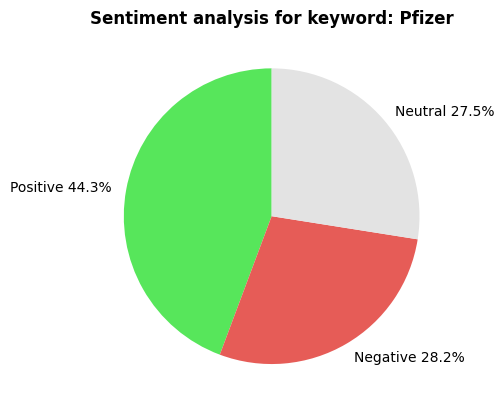

In [106]:
keyword = 'Pfizer'

pos = '#e65c57'
neg = '#57e65b'
neu = '#e3e3e3'

labels = ['Positive '+str(positive)+'%', 'Negative '+str(negative)+'%', 'Neutral '+str(neutral)+'%']

# f = plt.figure()
# f.set_figwidth(8)
# f.set_figheight(8)

sizes = [positive, negative, neutral]
colors = [neg,pos,neu]
patches, texts = plt.pie(sizes, labels=labels, colors=colors, startangle=90)



plt.style.use('default')
plt.title("Sentiment analysis for keyword: "+keyword, fontweight='bold')
plt.axis('off')
plt.show()

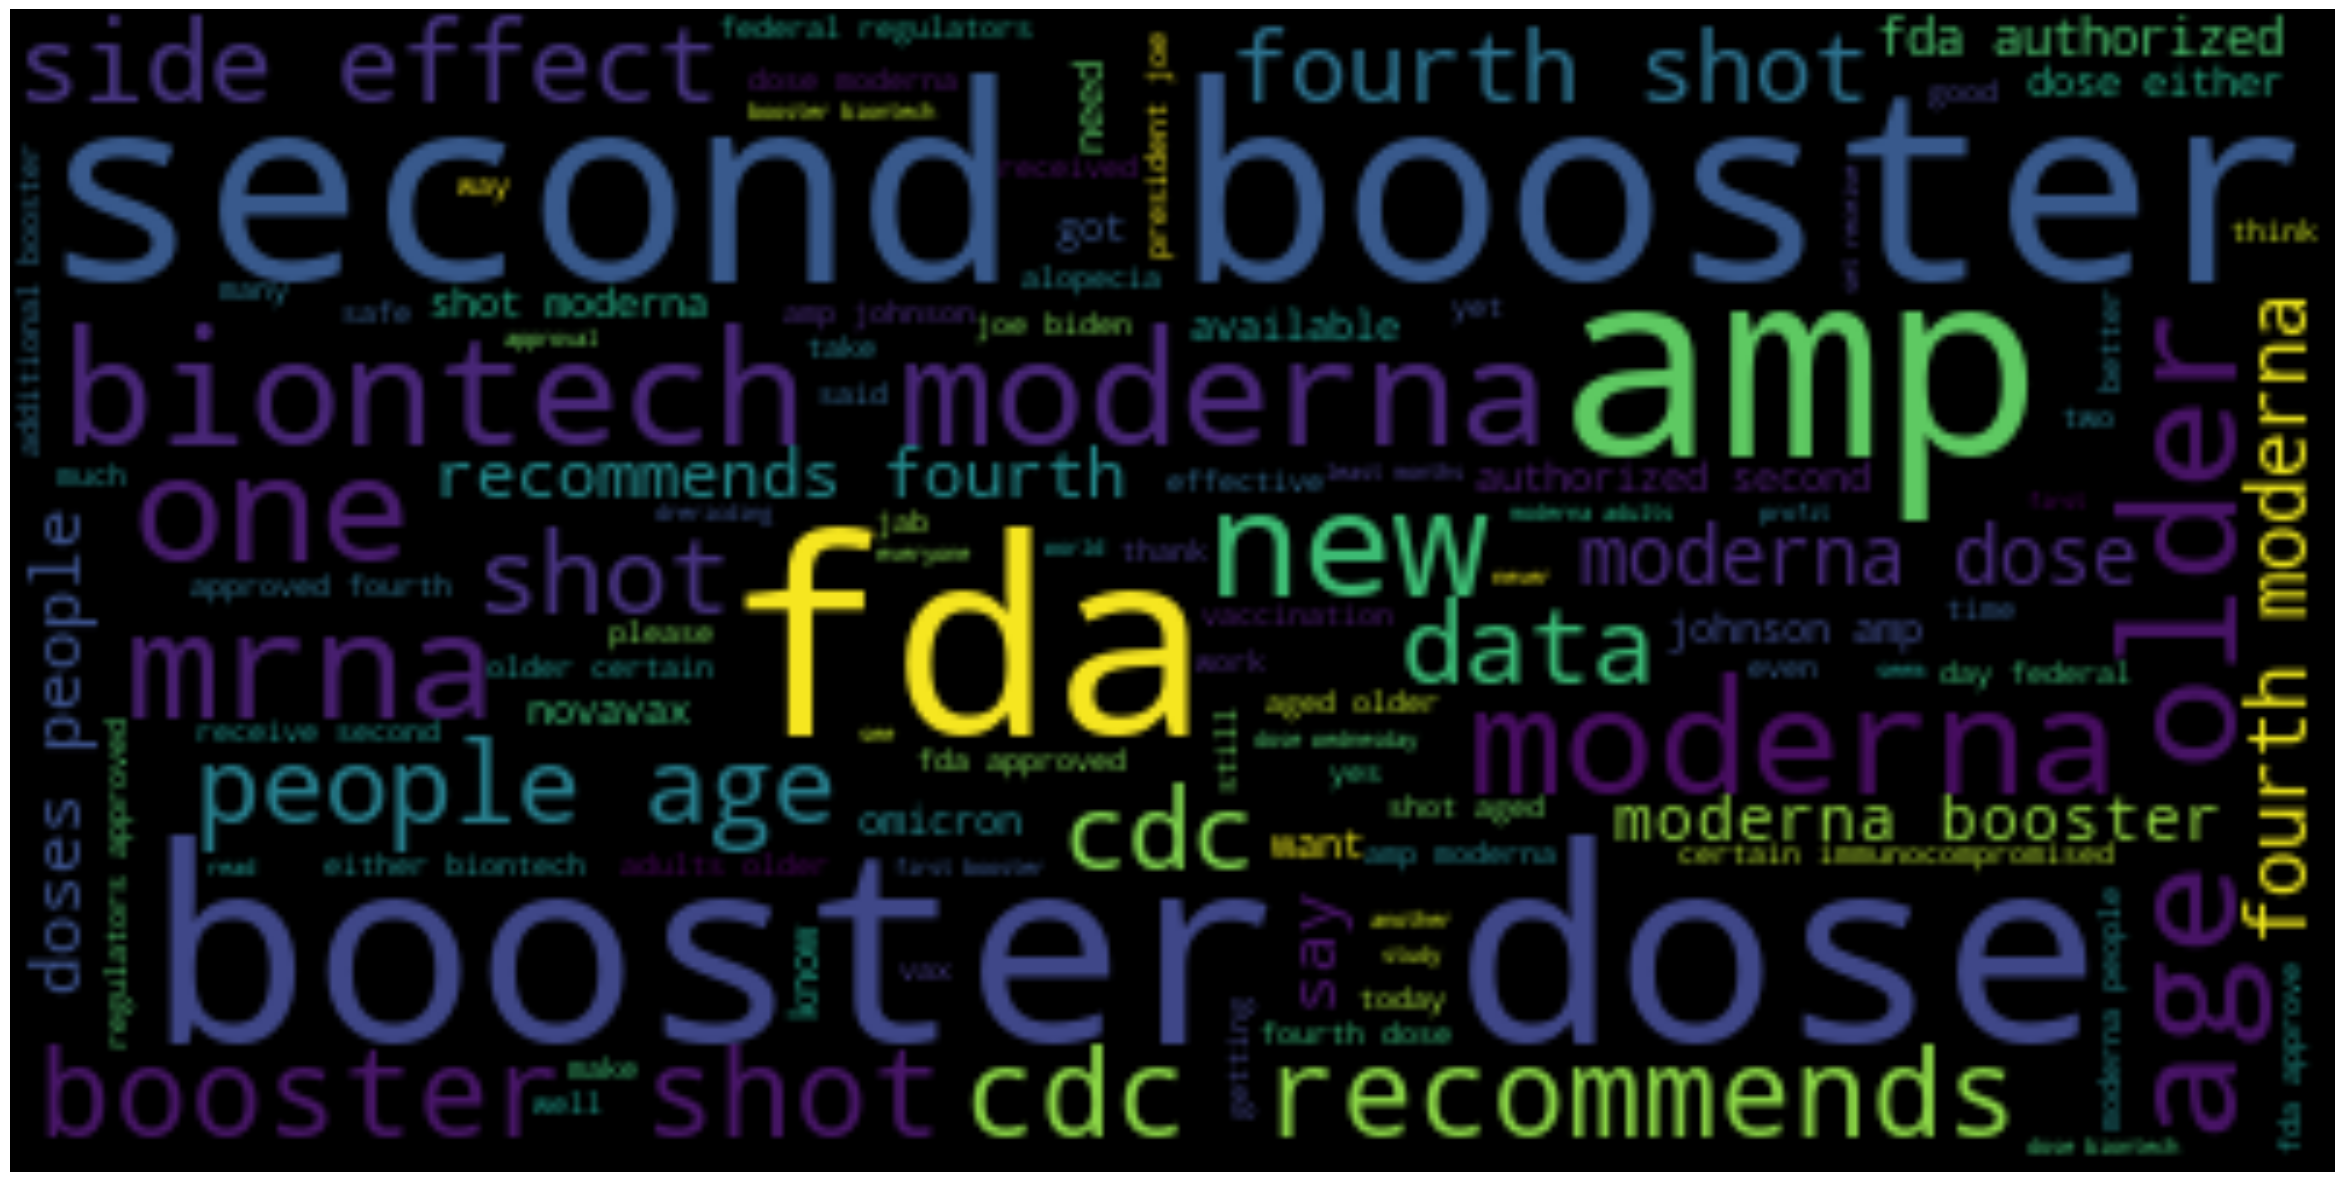

In [102]:
#positive tweet wordcloud
wordcloud = create_wordcloud(' '.join(positive_list[0]))
fig = plt.figure(1,figsize=(30, 50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

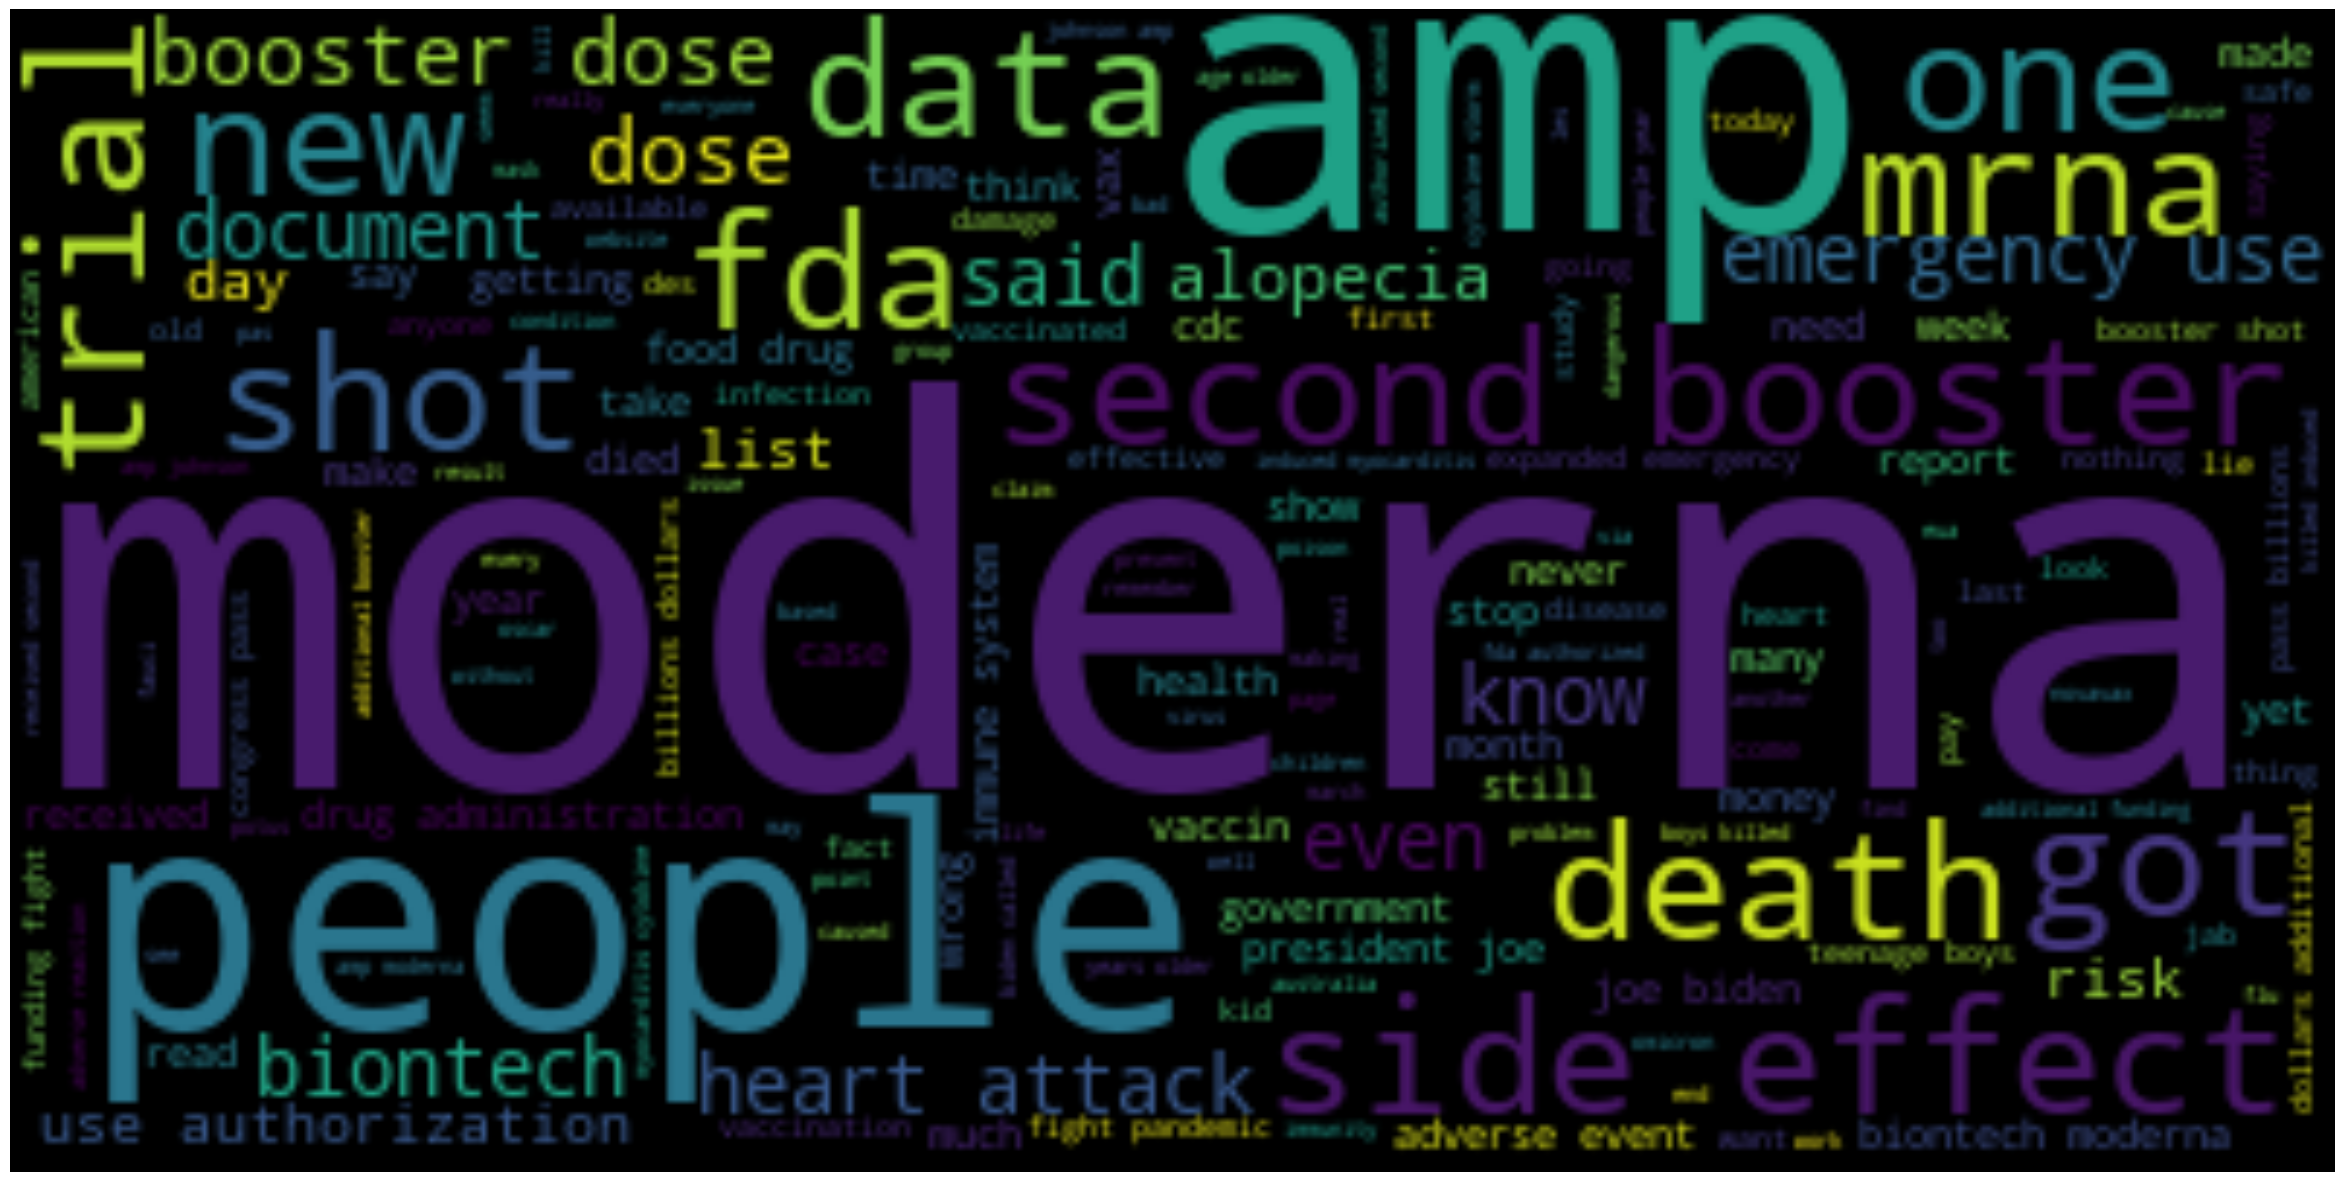

In [103]:
#negative tweet wordcloud
wordcloud = create_wordcloud(' '.join(negative_list[0]))
fig = plt.figure(1,figsize=(30, 50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [104]:
text = ' '.join(negative_list[0])
text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq = wordcloud.words_

#print results
print("Most frequent words: ")
print(list(word_freq.items())[0:50])
print("\nLeast frequent words:")
print(list(word_freq.items())[-100:-50])

Most frequent words: 
[('vaccine', 287), ('pfizer', 259), ('https', 237), ('covid vaccine', 129), ('pfizer vaccine', 103), ('pfizer moderna', 79), ('amp', 76), ('people', 63), ('fda', 52), ('side effect', 51), ('second booster', 49), ('shot', 48), ('death', 42), ('pfizer biontech', 41), ('data', 40), ('one', 37), ('new', 35), ('trial', 35), ('got', 33), ('booster dose', 32), ('dose pfizer', 31), ('pfizer covid', 31), ('emergency use', 28), ('know', 27), ('even', 25), ('list', 24), ('mrna vaccine', 24), ('said', 23), ('heart attack', 22), ('moderna vaccine', 22), ('alopecia', 21), ('use authorization', 21), ('drug administration', 20), ('adverse event', 20), ('many', 19), ('getting', 19), ('month', 19), ('joe biden', 19), ('risk', 18), ('time', 18), ('never', 18), ('moderna covid', 18), ('money', 17), ('government', 17), ('received', 17), ('vaccin', 17), ('day', 17), ('food drug', 17), ('think', 16), ('cdc', 16)]

Least frequent words:
[('rssc robw', 1), ('qflos jnzc', 1), ('jnzc joeblo